# A/B Testing Results Analysis for Website Conversion Rates

This project aims to determine the viability of changing a website from old design to new design based on conversion rates. The data represents how both versions of the webiste impacted conversion rates when launched to different users simulataneously. A/B testing is then conducted to determine which version of the website would be better in terms of impact on conversion rates.

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project, will be an attempt to understand the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [47]:
# importing essential libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Reading in the `ab_data.csv` data and Storing it in `df`, we will be able to see the description of the data as below.There are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

In [5]:
#reading the CSV file and assigning it to df variable
df = pd.read_csv('ab_data.csv') 
df.head() #displaying top 5 columns

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**1.** The cell below displays the number of rows in the dataset.

In [6]:
df.shape[0]

294478

**2.** The number of unique users in the dataset.

In [7]:
df.user_id.nunique()

290584

**3.** The proportion of users converted.

In [8]:
df.converted.mean()

0.11965919355605512

**4.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [9]:
#This value consists of the number of none matching group and landing_page associations
df.query('group == "treatment" & landing_page != "new_page"').shape[0] + df.query(\
                    'group == "control" & landing_page != "old_page"').shape[0]

3893

**5.** Checking rows for missing values

In [10]:
df.isnull().any() # No missing values in any columns

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

**6. *Creating a modified dataset that meets the specifications and storing in a new dataframe* df2**.

In [11]:
# Removing the inaccurate rows, and storing the result in a new dataframe df2
idx = df.query('group == "control" & landing_page != "old_page"').index
df2 = df.drop(idx)
idx2 = df2.query('group == "treatment" & landing_page != "new_page"').index
df2 = df2.drop(idx2)

In [12]:
# Double Checking that all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == \
                                       'new_page')) == False].shape[0]

0

**7.** Finding the number of unique **user_id**s in **df2**

In [13]:
df2.user_id.nunique()

290584

**8.** Identifying repeated  **user_ids** repeated in **df2**

In [14]:
df2[df2.user_id.duplicated()].user_id # repeated user ID is 773192

2893    773192
Name: user_id, dtype: int64

**9.** Displaying all data rows for the duplicate **user_id**

In [15]:
df2[df["user_id"] == 773192]

<ipython-input-15-0194bde22084>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2[df["user_id"] == 773192]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**10.** Removing **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [16]:
# Removes one of the rows with a duplicate user_id
df2.drop((df2[df2.user_id.duplicated()]).index, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().sum()

0

**11.** The probability of an individual converting regardless of the page they receive<br><br>


In [17]:
df2.converted.mean()

0.11959708724499628

**12.** The probability an individual converts, given that the individual was in the `control` group

In [18]:
df2[df2['group'] ==  'control'].converted.mean()

0.1203863045004612

**13.** The probability an individual converts, given that the individual was in the `treatment` group

In [19]:
df2[df2['group'] =='treatment'].converted.mean()

0.11880806551510564

In [20]:
# Calculating the observed difference (obs_diff) between the conversion rates for the two groups.
obs_diff = df2[df2['group'] ==  'control'].converted.mean() - df2[df2['group']\
                                                                  =='treatment'].converted.mean()
obs_diff

0.0015782389853555567

**14.** The probability that an individual received the new page

In [21]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

>**Considering the results from the previous parts, it seems the treatment group users don't generate more conversions than the control group users based on the numbers computed above.**

<a id='ab_test'></a>
## Part II - A/B Test

For now, consider that there is a need to make a decision based on just the data provided and the experiment will not run for longer time.  

> As per the computations just calculated above, the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page. 

Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses (**$H_0$** and **$H_1$**) for a hypothesis testing experiment be?

Stating the hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**$H_0$: $p_{new}$ - $p_{old}$ <= 0.**

>**$H_1$: $p_{new}$ - $p_{old}$ > 0.**

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, we will assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- The sampling distribution for the "difference in the converted probability" between the two simulated-samples will be performed over 10,000 iterations; then an estimated will be calculated. 

**1.** Finding the **conversion rate** for $p_{new}$ under the null hypothesis

In [22]:
p_new = df2.converted.mean()
p_new 

0.11959708724499628

**2.** Finding the **conversion rate** for $p_{old}$ under the null hypothesis

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**3.** Displaying $n_{new}$, the number of individuals in the treatment group <br><br>

In [24]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

**4.** Displaying $n_{old}$, the number of individuals in the control group

In [25]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

**5. Simulating Sample for the `treatment` Group**<br> 
Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [26]:
# Simulating a Sample for the treatment Group and storing values in new_page_converted
new_page_converted = np.random.choice([0,1], p = [1-p_new, p_new], size =n_new)

**6. Simulating Sample for the `control` Group** <br>
Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis, <br> then storing these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [27]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], p= [1-p_old, p_old], size = n_old)

**7.** Calculating the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the previous two parts. 

In [28]:
new_page_converted.mean() - old_page_converted.mean()

0.0013055260481739939


**8. Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in the parts above. 

<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [29]:
# Sampling distribution using random choice as a much faster option than generating samples from the data frame 
# using "df2.sample", as we are considering conversion values represented by 0's or 1's. This dramatically saves time.
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.choice([0,1], p = [1-p_old, p_old], size = n_old)
    new_page_converted =  np.random.choice([0,1], p = [1-p_new, p_new], size = n_new)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**9. Histogram**<br> 
Ploting a histogram of the **p_diffs**, and using `plt.axvline()` method to mark the actual difference observed in the `df2` data, in the chart.    .<br><br>

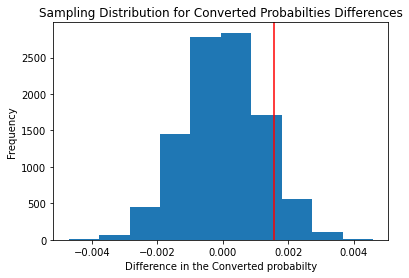

In [30]:
plt.hist(p_diffs);

plt.axvline(obs_diff, color = 'r'); #obs_diff represents the difference in conversion rates for the two groups
plt.xlabel('Difference in the Converted probabilty')
plt.ylabel('Frequency')
plt.title('Sampling Distribution for Converted Probabilties Differences');

**10.** Calculating the proportion of the **p_diffs** that are greater than the actual difference observed in the `df2` data

In [28]:
(p_diffs > obs_diff).mean()

0.0995

>**We have  just computed the proportion of values in the simulated sampling distribition under the null for the difference of 'Converted Probabilities' for the new page and the old page, that is greater than the observed 'Converted Probability' computed for the data in df2. This propotion is known as the P-value. The P-value indicates the statistical significance of the data obtained from the simulated sampling distribution under the null, in comparison to our set Type 1 error threshold, which in this case is 5%. 
Since the computed P-value is approximately 9.95%, which is larger than the 5% threshold set, that suggests that differences of "Converted Probabilities' computed for the new page and the old page in the sampling distribution under the null are insignificant, and therefore: We Fail to Reject The Null Hypothesis**



**11. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly think about statistical significance. 

The statements below explains what we will calculate in the next part:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

**12.** Now we will use `sm.stats.proportions_ztest()` to compute the test statistic and p-value.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Key**: <br>
It's a two-tailed if $H_1$ is defined as $(p_{new} = p_{old})$. <br>
It's a left-tailed if $H_1$ is defined as $(p_{new} < p_{old})$. <br>
It's a right-tailed if $H_1$ is defined as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that we have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. The $Z_{\alpha}$ can be determined from the z-table manually. 

We will then reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.


For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 

---

In [32]:
import statsmodels.api as sm
# Using the sm.stats.proportions_ztest() method and the arguments which we defined above to determine the z_score and p_value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**13.** Interpreting the new test results and comparing them to the results of the previous test:<br><br>

>**The computed Z score in the previous question is approximately -1.3109 , which for a right-tailed test with an alpha of 0.05 , is certainly less than the corresponding Z-value of 1.64. Also, the computed P-value using the z-test is much greater than our 5% Type one error threshold. Even though the P-value from this test is not the same as the P-value computed in the previous part, the conclusion remains the same as previously stated.
Conclusion: We Fail to Reject The Null Hypothesis**

<a id='regression'></a>
### Part III - A Regression Approach

In this final part, you will see that the results we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**1.** Since each row in the `df2` data is either a conversion or no conversion, the type of regression that should be performed is **Logistic Regression**

**2.** The goal is to use **statsmodels** library to fit a logistic regression model to see if there is a significant difference in conversion based on the page-type a customer receives. However, first we need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - A dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [33]:
df2['intercept'] = 1

df2[['control_page', 'ab_page']] = pd.get_dummies(df['group'])

**3.** Using **statsmodels** to instantiate the regression model on the two columns created above, then fitting the model to predict whether or not an individual converts.


In [34]:
logistic_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**4.** Displaying the summary of the model below:

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-02 12:15 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**5.** Interpreting the new test results and comparing them to the results of the previous tests:<br><br>  


>**The p-value associated with ab_page according to the above logistic regression model is 18.99% which is still larger than our 5% set Type one error indicating that we still can conclude failing to reject the null hypothesis.
Since Logistic Regression is used to predict only TWO possible outcomes, the Null Hypothesis here has become Two Tailed, represented by the following notation:**
>>**$H_0$: $p_{new}$ = $p_{old}$**
**And the Alternative Hypothesis can be represented by:**
>>**$H_1$: $p_{new}$ ≠ $p_{old}$ .**
>**This consequently resulted in the observed change in the p-value computed in the Logistic Regression model**

**6.**  Additional considerations:

>**Adding additional factors to the regression model is a good idea to improve it's prediction ability. Other factors like age, income and location for example could greatly influence whether an individual converts or not in reality. To elaborate, a website that ships only to europe may get visitors from other areas, these individuals by default will be unable to 'convert'. Same thing applies to age if the site only sells products that are for individuals above 18, all visitors below that age won't be able to 'convert', and so on. 
However, there may be disadvantges to adding additional factors. For example, if some of these additional predictor variables are highly correlated, it may result in Multicollinearity phenomenon, which in turn will be resulting in a misleading interpretation of the generated outputs.**

**7. Adding countries**<br> 
Along with testing if the conversion rate changes for different pages, we will now add an effect based on which country a user lives in. 

1. Will now read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows, and calling the resulting dataframe `df_merged`.

2. Will the consider if there is any impact for adding countries. There are three unique values, `['UK', 'US', 'CA']`, in the `country` column for which we will be creating dummy variables for these country columns. 

In [36]:
# Reading the countries.csv
countries = pd.read_csv('countries.csv')

In [37]:
# Joining with the df2 dataframe
df_merged = df2.join(countries.set_index('user_id'), on = 'user_id')

In [38]:
# Creating the necessary dummy variables
df_merged[['CA','UK', 'US']] = pd.get_dummies(df_merged['country'])

logistic_model2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA', 'UK']])
results2 = logistic_model2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2022-03-02 12:31 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [39]:
np.exp(-0.0408), np.exp(0.0099)

(0.9600211149716509, 1.0099491671175422)

>**The results from the above Logistic Regression model suggest that countries doesn't have an impact on conversion. The p-values computed indicates statistical insignficance and the coefficients generated show that conversion in the UK and CA is almost the same (slight differences) as compared to the US , which acted as the baseline in the model.**

In [40]:
logistic_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK']])
results_new = logistic_mod.fit()
results_new.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-03-02 12:32 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [41]:
np.exp(-0.0408), np.exp(0.0099)

(0.9600211149716509, 1.0099491671175422)

>**The Logistic Regression model results including countries as well as the ab_page, still suggest that countries doesn't have an impact on conversion. The p-values computed has slightly changed but still indicate statistical insignficance and the coefficients generated are identical to the ones computed in the previous part. The conversion in the UK and CA is almost the same (slight differences) as compared to the US , which acted as the baseline in the model and practically, these differnces are negligible. Thus, the conclusion remains the same: we Fail to Reject the Null Hypothesis**

**8. Fit your model and obtain the results**<br> 
Since we now have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.


In [42]:
#logistic model interaction for page and country

df_merged['interaction_CA'] = df_merged['ab_page'] * df_merged['CA']
df_merged['interaction_UK'] = df_merged['ab_page'] * df_merged['UK']

logistic_model3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK','interaction_CA', 'interaction_UK']])
results3 = logistic_model3.fit()

results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-02 12:37 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9865   0.0096 -206.3440 0.0000 -2.0053 -1.9676
ab_page          -0.0206   0.0137   -1.5052 0.1323 -0.0473  0.0062
CA               -0.0175   0.0377   -0.4652 0.6418 -0.0914  0.0563
UK               -0.0057   0.0188   -0.3057 0.7598 -0.0426  0.0311
interaction_CA   -0.0469   0.0538   -0.8718 0.3833 -0.1523  0.0585
interaction_UK    0.0314   0.0266    1.1807 0.2377 -0.0207  0.0835
==================================================================

"""

In [43]:
np.exp(-0.0469), np.exp(0.0314)

(0.9541828111007262, 1.0318981806179213)

>**Adding interaction terms to the Logistic Regression model slightly adjusted the computed coefficients for better accuracy but the changes are too marginal to be considered. To be clear, Conversions in CA and UK as compared to US are only 0.95 times and 1.032 times that of the US, which is too low to be considered from a practical prespective. The p-values also suggest insignificance of the values computed as they are also larger than the 5% Type one error rate set.**

**Assesing the accuracy of the model:**

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

y = df_merged['converted']

X = df_merged[['ab_page','CA','UK']]

Xtrain, Xtest, ytrain, ytest =train_test_split(X,y,test_size=0.20, random_state=0)

log_mod = LogisticRegression()

log_mod.fit(Xtrain, ytrain)

ypreds = log_mod.predict(Xtest)

In [46]:
print(accuracy_score(ytest, ypreds))

0.8802243749677375


>**The Logistic Model above has an accuracy of 88% approximately. Since this is a logistic regression model with only two possible outcomes: "Converted" OR "Not Converted", it is useless to compute Recall or Precision, as the model will not be predicting False Positives or Negative Positives.**

## Conclusion:

>The Logistic Regression model has yielded p-values which indicate insignificant influence for a specific page over the other on conversion rates. This is also true for the effect of location on conversion rates, as no specific country had a conversion rate that stood out as compared to the baseline of the model, and also, no specific country had a conversion rate for a specific page that was high enough to suggest that one page is out perfroming the other in terms of conversion rates in a specific location; or in general for that matter. To sum up:
    - We Fail to Reject the Null Hypothesis.
    - There is no practical gains from implementing the new page even at specific locations.
    - We recomment NOT applying the new page based on the collected data so far.

<a id='finalcheck'></a>
## Prepared by: Mahmoud Badr